In [1]:
import os
os.environ.update(
    OMP_NUM_THREADS="1", OPENBLAS_NUM_THREADS="1", NUMEXPR_NUM_THREADS="1", MKL_NUM_THREADS="1"
)

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import arviz as az
import corner

from util import phasefold, get_stats, plot_binned

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
# Numbers from teh SPOC S1-39 multisector https://tev.mit.edu/data/delivered-signal/i226894/
period = 1.74469
epoch = 1326.9843
ror = 0.0123
duration = 1.1574 / 24 # in days

In [4]:
tic_info = pd.read_csv("data/tic_82.csv", index_col=0).T

In [5]:
lc = pd.read_csv("data/lc.csv", index_col=0)
lc = lc[lc["quality"] == 0]
phase = phasefold(lc["time"], period, epoch)
intran = np.abs(phase) < 2 * duration / period
lc = lc[intran]
print(lc.shape)

(48826, 24)


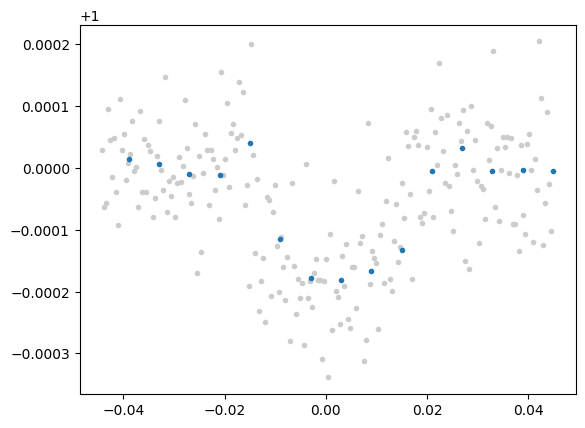

In [6]:
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], period, epoch, bins=int(period/(15/60/24)))

In [8]:
with pm.Model() as model:
    t0 = pm.Uniform("t0", lower=epoch - .1 * period, upper = epoch + .1 * period)
    per = pm.Uniform("per", lower=0.9*period, upper=1.1*period)
    
    dur = pm.Uniform("dur", lower=0, upper=2*duration)
    ror = pm.Uniform("ror", lower=0, upper=2, testval=np.sqrt(-depth))
    b = pm.Uniform("b", lower=-(ror + 1), upper=(ror + 1))
    
    r_star = pm.Uniform("r_star", lower=0, upper=2)
    
    orbit = xo.orbits.SimpleTransitOrbit(
        per,
        dur,
        t0=t0,
        r_star=r_star,
        ror=ror,
        b=b,
    )
    u = xo.distributions.QuadLimbDark("u")
    lcs = pm.Deterministic(
        "lcs",
        xo.LimbDarkLightCurve(u).get_light_curve(
            orbit=orbit,
            r=ror*r_star,
            t=lc["time"],
            texp=0.00138889, # 2 min
            oversample=3, # update to 5 or 7 when ready
        )
    )
    mean = pm.Normal("mean", mu=1.0, sd=0.5)
    full_lc = tt.sum(lcs, axis=-1) + mean
    pm.Deterministic("full_lc", full_lc)
    
    # Observation model
    pm.Normal("obs", mu=full_lc, sd=lc["flux_err"], observed=lc["flux"], shape=len(lc))

In [9]:
# Find MAP parameter solution
# This helps us make sure our model is set up reasonably and
# will give MCMC a starting point
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[mean])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 266994.42522984697 -> 266994.83447332145
optimizing logp for variables: [mean, u, r_star, b, ror, dur, per, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 266994.83447332145 -> 267029.3510067873


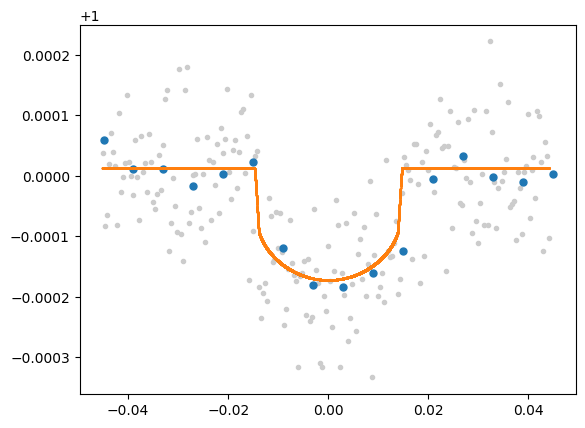

In [10]:
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], map_soln["per"], map_soln["t0"], bins=int(period/(15/60/24)), s=100)
plot_binned(lc["time"], map_soln["full_lc"], map_soln["per"], map_soln["t0"], s=1)

In [13]:
# Run MCMC!
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=5,
        chains=5,
        target_accept=0.90,
        return_inferencedata=True,
        init="adapt_full",
    )

/var/folders/_6/pj6xmt2x1d37wcs5_nq_5zd00000gn/T/ipykernel_2775/2774743949.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [mean, u, r_star, b, ror, dur, per, t0]


/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tey/.pyenv/versions/3.10.1/envs/toi-486/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


In [ ]:
pm.save_trace(trace)
# '.pymc_1.trace' 11/18/22
# Run notes: 1000 1000 on 5 cores takes 15 min, but doesn't have good convergence 

In [14]:
az.summary(trace, var_names=["per", "t0", "dur", "ror", "b", "u", "r_star", "mean"])
# # Check that r_hat is close to 1
# stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
per,1.745,0.000,1.745,1.745,0.000,0.000,1381.0,646.0,1.01
t0,2387.760,0.001,2387.758,2387.762,0.000,0.000,169.0,374.0,1.03
dur,0.053,0.003,0.049,0.059,0.001,0.000,40.0,12.0,1.09
ror,0.013,0.001,0.011,0.016,0.000,0.000,41.0,17.0,1.09
b,0.029,0.571,-0.818,0.968,0.064,0.064,47.0,17.0,1.07
u[0],0.710,0.363,0.046,1.330,0.013,0.010,765.0,710.0,1.01
u[1],0.002,0.370,-0.615,0.707,0.010,0.008,1243.0,1781.0,1.01
r_star,0.979,0.569,0.071,1.933,0.025,0.018,584.0,1235.0,1.01
mean,1.000,0.000,1.000,1.000,0.000,0.000,2535.0,2630.0,1.01


In [15]:
def get_rho(period, duration, depth, transit_shape):
    # following 1.14 from aude thesis
    G = 2942 # Rsun^3 / Msun / day^2, so return is in solar densities
    # this has some assumptions so i should check them
    return 32 * period * depth**0.75 / G / 3.14159 / duration**3 / (1 - transit_shape**2)**1.5

def get_transit_shape(ror, b):
    # Eq 1.4 from https://www.astro.ex.ac.uk/people/alapini/Publications/PhD_chap1.pdf
    return np.sqrt(((1 - ror) ** 2 - b ** 2) / ((1 + ror) ** 2 - b ** 2))

In [16]:
samples = trace.posterior.stack(sample=("chain", "draw"))

ror [158.4 118.3 317.7]

shp 1 [0.967 0.953 0.973]
shp 2 [0.967 0.8   0.977]
shp 3 [0.967 0.544 0.978]

qin 1 [0.017 0.013 0.024]
qin 2 [0.017 0.012 0.1  ]
qin 3 [0.017 0.011 0.228]

rho [3.516 0.092 6.738]

dmag 1 [0.7 0.3 1.3]
dmag 2 [0.7 0.  4.2]
dmag 3 [0.7 0.  6.4]


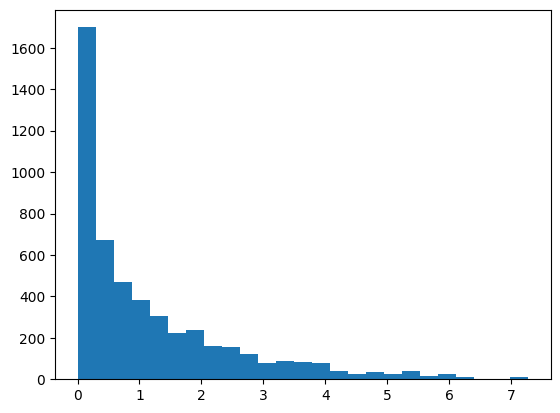

In [17]:
transit_shape_samples = get_transit_shape(samples["ror"], samples["b"])
rho_samples = get_rho(samples["per"], samples["dur"], samples["ror"]**2, transit_shape_samples)

d_blend_samples = (1 - transit_shape_samples)**2 / (1 + transit_shape_samples)**2
d_blend_samples = (1 - transit_shape_samples)**2 / (1 + transit_shape_samples)**2
d_obs_samples = samples["ror"]**2

# treat tmag as total mag
f = d_obs_samples / d_blend_samples
dmag_samples = - 2.5 * np.log10(f)
plt.hist(dmag_samples, bins=25)

print("ror", np.round(get_stats(samples["ror"]**2*10**6, sigma=3), 1))
print()

print("shp 1", np.round(get_stats(transit_shape_samples, sigma=1), 3))
print("shp 2", np.round(get_stats(transit_shape_samples, sigma=2), 3))
print("shp 3", np.round(get_stats(transit_shape_samples, sigma=3), 3))
print()

print("qin 1", np.round(get_stats((1-transit_shape_samples)/2, sigma=1), 3))
print("qin 2", np.round(get_stats((1-transit_shape_samples)/2, sigma=2), 3))
print("qin 3", np.round(get_stats((1-transit_shape_samples)/2, sigma=3), 3))
print()

print("rho", np.round(get_stats(rho_samples, sigma=3), 3))
print()

print("dmag 1", np.round(get_stats(dmag_samples, sigma=1), 1))
print("dmag 2", np.round(get_stats(dmag_samples, sigma=2), 1))
print("dmag 3", np.round(get_stats(dmag_samples, sigma=3), 1))


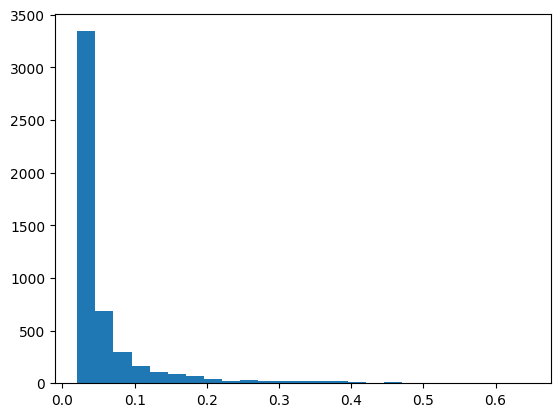

In [18]:
# t_flat / t_total
plt.hist(1 - transit_shape_samples, bins=25)
plt.show()

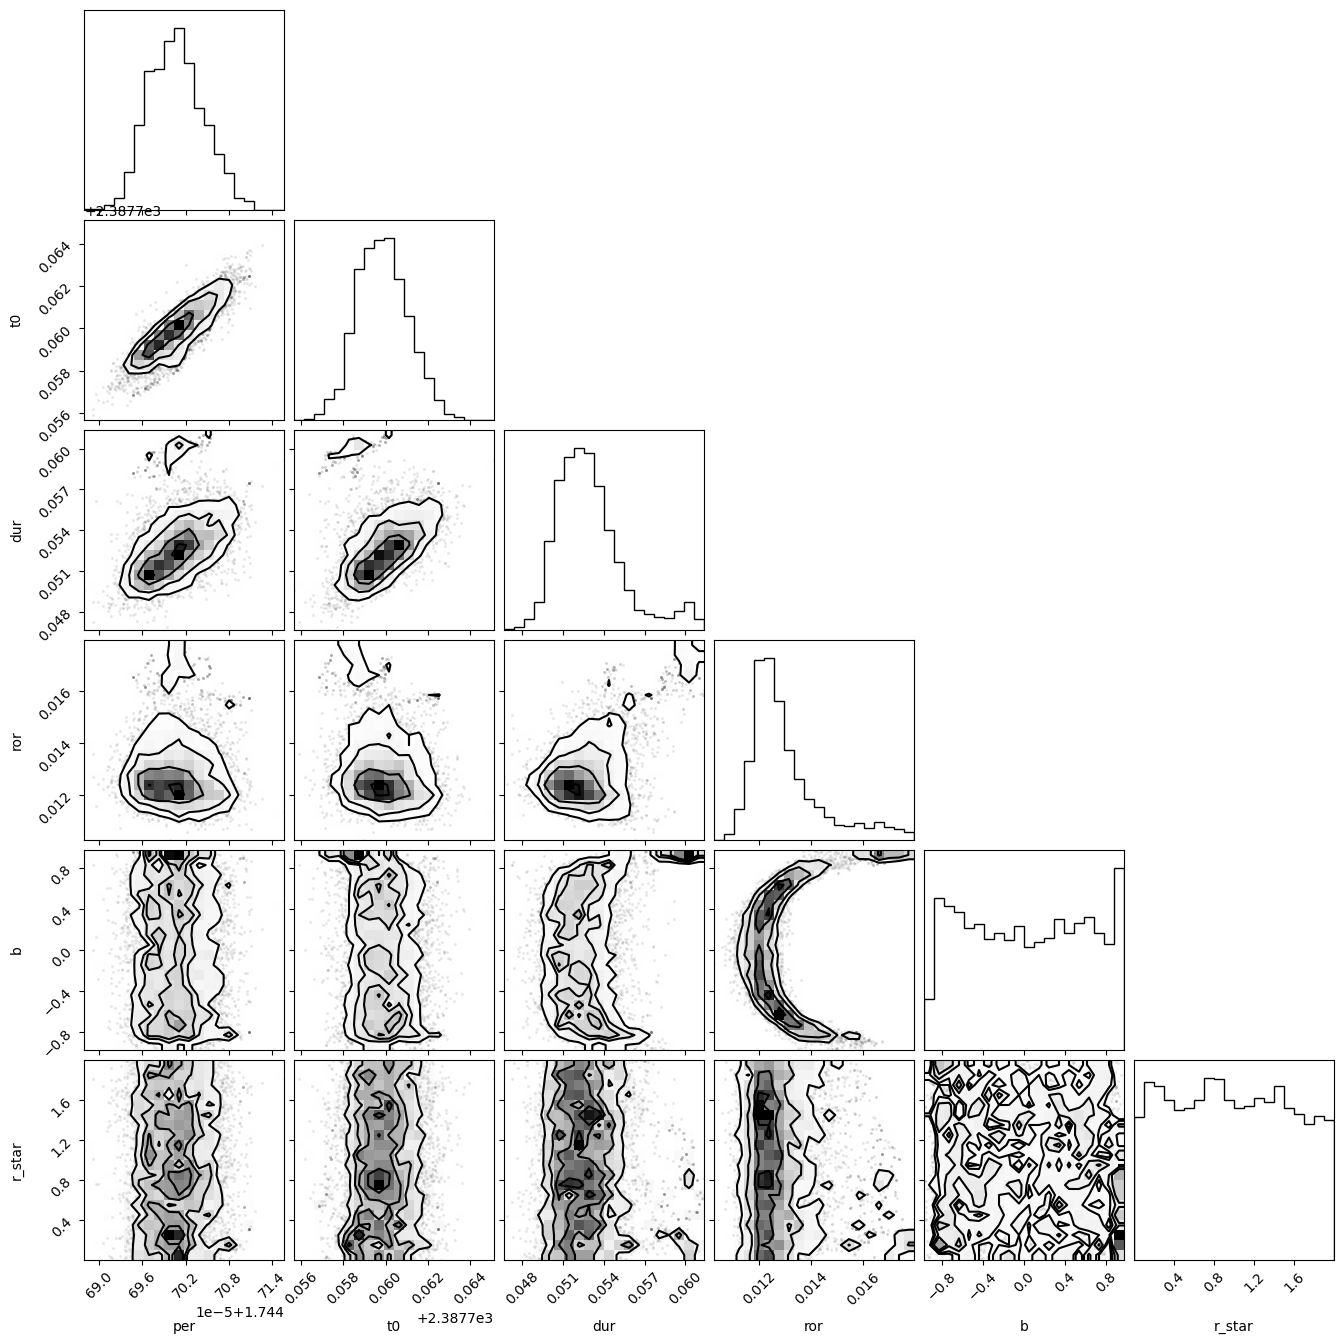

In [ ]:
_ = corner.corner(
    trace,
    var_names=["per", "t0", "dur", "ror", "b", "r_star"]
)

In [20]:
median_lc = np.nanmedian(samples["full_lc"], axis=1)
median_per = np.nanmedian(samples["per"])
median_t0 = np.nanmedian(samples["t0"])

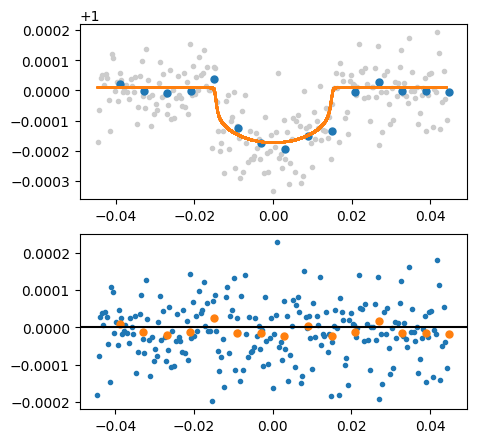

In [21]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plot_binned(lc["time"], lc["flux"], median_per, median_t0, bins=int(period/(1/60/24)), color="0.8")
plot_binned(lc["time"], lc["flux"], median_per, median_t0, bins=int(period/(15/60/24)), s=100)
plot_binned(lc["time"], median_lc, median_per, median_t0, s=1)

plt.subplot(2, 1, 2)
plot_binned(lc["time"], lc["flux"] - median_lc, median_per, median_t0, bins=int(period/(1/60/24)))
plot_binned(lc["time"], lc["flux"] - median_lc, median_per, median_t0, bins=int(period/(15/60/24)), s=100)
plt.axhline(0, color="k")

In [ ]:
"""
TODO:
- skim avi's stuff and figure out what's needed
- make a physical model + fit
    - display results of that fit with correct uncertainties
    - make a publication ready plot
- keep this transit shape model?
    - figure out what numbers we want, and print them as well
"""